In [1]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt

In [2]:
def display_image(img):
    plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
    plt.axis("off")

def overlay_fixed_moving(fixed, moving):
    img1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    img2 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    cimg = sitk.Compose(img1, img2, sitk.Cast(img1/2. + img2/2., sitk.sitkUInt8))
    plt.imshow(sitk.GetArrayFromImage(cimg))
    plt.axis("off")

# Affine Registration

The affine transform allows for shearing and scaling in addition to the rotation and translation. This is usually a good choice of transform for initialization of non-rigid transforms like the B-Spline transform. The affine transform is selected using `sitk.GetDefaultParameterMap("affine")`.

In [3]:
dataPath = os.path.join(os.sep, "Users", "tannersorensen", "SimpleElastix-fork", \
                        "SimpleElastix-build", "SimpleITK-build", "ExternalData", \
                        "Testing", "Data", "Input")

fixedFilename = "BrainProtonDensitySliceShifted13x17y.png"
fixedImage = sitk.ReadImage(os.path.join(dataPath, fixedFilename), sitk.sitkUInt8)

movingFilename = "BrainProtonDensitySliceR10X13Y17.png"
movingImage = sitk.ReadImage(os.path.join(dataPath, movingFilename), sitk.sitkUInt8)

Consider the original image (left) and translated and rotated image (right) in the figure below.

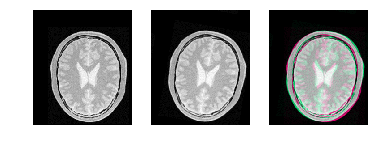

In [4]:
# fixed image
plt.subplot(1,3,1)
display_image(fixedImage)

# moving image
plt.subplot(1,3,2)
display_image(movingImage)

# fixed image (red) and moving image (green),
# with overlap in white
plt.subplot(1,3,3)
overlay_fixed_moving(fixedImage, movingImage)

The image on the right has been sheared, scaled 1.2x, rotated 10 degrees and translated 13 pixels in the x-direction and 17 pixels in the y-direction. Using the `AdvancedAffineTransform` we may correct for this misalignment.

In [6]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
elastixImageFilter.Execute()
resultImage = elastixImageFilter.GetResultImage()
sitk.WriteImage(sitk.Cast(resultImage, sitk.sitkUInt8), "affine_result_"+movingFilename)

It is clear from the result mean image after registration on the right in the figure below that registration was successful.

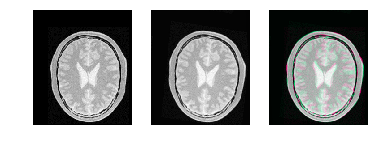

In [7]:
# fixed image
plt.subplot(1,3,1)
display_image(fixedImage)

# registered moving image (result)
plt.subplot(1,3,2)
display_image(resultImage)

# fixed image (red) and registered 
# moving image (green), with overlap in white
# note that the images completely overlap
# (i.e., no red or green)
plt.subplot(1,3,3)
overlay_fixed_moving(fixedImage, resultImage)

Notice that the only difference from the previous example is the requested parameter map. In fact, only the Transform parameter seperates the two parameter maps. The following parameter map is equivalent to the one used above:

In [8]:
parameterMap = sitk.GetDefaultParameterMap("rigid")
parameterMap["Transform"] = ["AffineTransform"]

#TODO: correct the URL

You can inspect the default parameter maps in the [elastix repository](https://github.com/mstaring/elastix/blob/617b0729fb6200fce279f7e6388967c6315ddc90/src/Core/Main/elxParameterObject.cxx#L260-L362) to convince yourself.

This demonstrates how easy it is to try out different registration components with SimpleElastix. In the next example we will introduce non-rigid registration and initialize the moving image with an affine transform.